# Phase 2 – Supervised Learning Benchmark

Benchmark supervised intent classifiers for **VoyageAI** using the labeled
utterances generated in Phase 2.


## Objectives
- Compare at least two supervised models on identical features.
- Provide justification for algorithm selection.
- Implement, tune, and evaluate each model.
- Interpret the comparative results for deployment guidance.


> **Labeling note:** The train/test CSVs come directly from the zero-shot classifier (`facebook/bart-large-mnli`).
> Each utterance receives only the single highest-probability intent. Compound lines (e.g. greetings that also request a booking) can therefore be mislabeled. Review and correct the CSVs if you need a gold-standard set or richer multi-intent coverage.


## Zero-Shot Labeling Script (Reference)
This is the exact script we used in Phase 1 to auto-label `conversation2.csv` with intents.
Re-run it only if you need to regenerate the CSVs—it downloads the zero-shot model and
can take a few minutes.


In [ ]:
# WARNING: Running this cell will download `facebook/bart-large-mnli` and overwrite the
# outputs in `Dataset/phase2_outputs/`. Use only when you need to regenerate labels.

import re
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import pipeline

INTENT_LABELS = [
    "greeting",
    "book_hotel",
    "provide_dates",
    "provide_location",
    "ask_info",
    "confirmation",
]

source_path = Path("Dataset/conversation2.csv")
if not source_path.exists():
    raise FileNotFoundError("conversation2.csv not found. Check the Dataset folder.")

# Load the raw conversation file
raw_df = pd.read_csv(source_path)

# Heuristic parsing: extract segments that start with `###Human:` (case-insensitive)
human_pattern = re.compile(r"###\s*Human\s*:\s*(.*?)(?=(###\s*(?:Human|Assistant)\s*:|$))", re.IGNORECASE | re.DOTALL)

utterances = []
source_rows = []
text_cols = [col for col in raw_df.columns if any(key in col.lower() for key in ["text", "utterance", "message", "content", "sentence"])]
if not text_cols:
    raise KeyError("Could not find a text column in conversation2.csv.")

for idx, entry in raw_df[text_cols[0]].fillna("").astype(str).items():
    for match in human_pattern.finditer(entry):
        cleaned = re.sub(r"\s+", " ", match.group(1)).strip()
        if cleaned:
            utterances.append(cleaned)
            source_rows.append(idx)

if not utterances:
    raise ValueError("No human utterances were extracted. Check the parsing rules.")

print(f"Detected {len(utterances)} human utterances for labeling.")
zeroshot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
results = zeroshot(utterances, INTENT_LABELS, multi_label=False)

labeled_df = pd.DataFrame(
    {
        "utterance": utterances,
        "intent": [res["labels"][0] for res in results],
        "source_row": source_rows,
    }
)

output_dir = Path("Dataset/phase2_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

labeled_df.to_csv(output_dir / "conversation2_labeled.csv", index=False)
train_df, test_df = train_test_split(
    labeled_df, test_size=0.2, random_state=42, stratify=labeled_df["intent"]
)
train_df.to_csv(output_dir / "conversation2_train.csv", index=False)
test_df.to_csv(output_dir / "conversation2_test.csv", index=False)

print(f"Saved labeled splits to {output_dir.resolve()}")


## Algorithm Selection & Justification
We focus on two linear workhorses for sparse text classification:

1. **Logistic Regression (One-vs-Rest)** – Fast, probabilistic, interpretable; class
   weighting combats the skewed intent frequencies.
2. **Linear Support Vector Machine** – Maximizes the margin under hinge loss and
   often yields superior macro-F1 on TF-IDF features.

Both use the same TF-IDF encoder so the comparison isolates classifier behavior.


In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

sns.set_theme(style="whitegrid")


## Data Loading & Summary


In [2]:
data_dir = Path("Dataset/phase2_outputs")
train_path = data_dir / "conversation2_train.csv"
test_path = data_dir / "conversation2_test.csv"

if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError(
        "Missing Phase 2 splits. Generate them in Phase1_Data_Exploration.ipynb."
    )

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train = train_df["utterance"].astype(str)
y_train = train_df["intent"].astype(str)
X_test = test_df["utterance"].astype(str)
y_test = test_df["intent"].astype(str)

summary = (
    train_df["intent"].value_counts().rename("train_count").to_frame()
    .join(y_test.value_counts().rename("test_count"), how="outer")
    .fillna(0)
    .astype(int)
    .sort_index()
)

display(summary)


,train_count,test_count
intent,,
ask_info,138,35
book_hotel,2,1
confirmation,224,56
greeting,194,48
provide_location,401,100


## Implementation, Training & Evaluation


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


- **Logistic Regression** best params: `{'clf__C': 2.0}`

- **Linear SVM** best params: `{'clf__C': 2.0}`

,model,accuracy,macro_precision,macro_recall,macro_f1
0,Linear SVM,0.971,0.979,0.974,0.976
1,Logistic Regression,0.933,0.829,0.935,0.847


#### Classification Report — Logistic Regression

                  precision    recall  f1-score   support

        ask_info      0.967     0.829     0.892        35
      book_hotel      0.333     1.000     0.500         1
    confirmation      0.929     0.929     0.929        56
        greeting      1.000     0.958     0.979        48
provide_location      0.914     0.960     0.937       100

        accuracy                          0.933       240
       macro avg      0.829     0.935     0.847       240
    weighted avg      0.940     0.933     0.935       240



#### Classification Report — Linear SVM

                  precision    recall  f1-score   support

        ask_info      0.971     0.943     0.957        35
      book_hotel      1.000     1.000     1.000         1
    confirmation      0.964     0.946     0.955        56
        greeting      1.000     1.000     1.000        48
provide_location      0.961     0.980     0.970       100

        accuracy                          0.971       240
       macro avg      0.979     0.974     0.976       240
    weighted avg      0.971     0.971     0.971       240



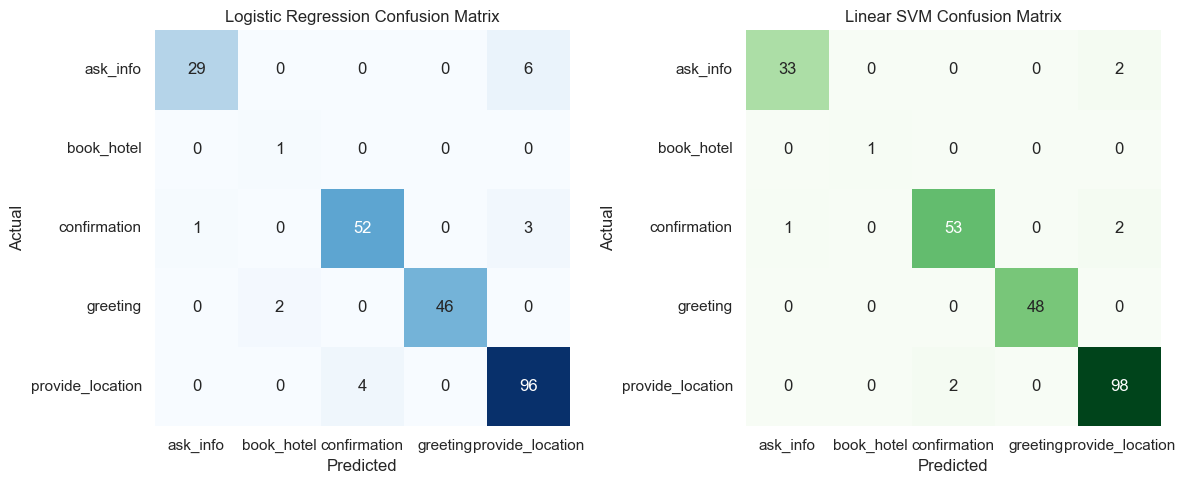

In [3]:
tfidf_config = dict(stop_words="english", ngram_range=(1, 2), min_df=2)

model_configs = {
    "Logistic Regression": {
        "pipeline": Pipeline(
            steps=[
                ("tfidf", TfidfVectorizer(**tfidf_config)),
                (
                    "clf",
                    LogisticRegression(
                        max_iter=2000,
                        class_weight="balanced",
                        random_state=42,
                        solver="liblinear",
                    ),
                ),
            ]
        ),
        "param_grid": {"clf__C": [0.25, 0.5, 1.0, 2.0]},
    },
    "Linear SVM": {
        "pipeline": Pipeline(
            steps=[
                ("tfidf", TfidfVectorizer(**tfidf_config)),
                (
                    "clf",
                    LinearSVC(class_weight="balanced", random_state=42, max_iter=5000),
                ),
            ]
        ),
        "param_grid": {"clf__C": [0.5, 1.0, 2.0]},
    },
}

results = []
best_params = {}
classification_reports = {}
confusion_matrices = {}
label_order = sorted(train_df["intent"].unique())

for model_name, cfg in model_configs.items():
    grid = GridSearchCV(
        estimator=cfg["pipeline"],
        param_grid=cfg["param_grid"],
        scoring="f1_macro",
        cv=3,
        n_jobs=-1,
    )
    grid.fit(X_train, y_train)

    best_params[model_name] = grid.best_params_

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    results.append(
        {
            "model": model_name,
            "accuracy": acc,
            "macro_precision": macro_precision,
            "macro_recall": macro_recall,
            "macro_f1": macro_f1,
        }
    )

    classification_reports[model_name] = classification_report(y_test, y_pred, digits=3)
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred, labels=label_order)

# Summary metrics and tuned hyperparameters
for name, params in best_params.items():
    display(Markdown(f"- **{name}** best params: `{params}`"))

metrics_df = pd.DataFrame(results).sort_values("macro_f1", ascending=False).reset_index(drop=True)
display(metrics_df.style.format({
    "accuracy": "{:.3f}",
    "macro_precision": "{:.3f}",
    "macro_recall": "{:.3f}",
    "macro_f1": "{:.3f}",
}))

for name, report_text in classification_reports.items():
    display(Markdown(f"#### Classification Report — {name}"))
    print(report_text)

fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(6 * len(confusion_matrices), 5))
if len(confusion_matrices) == 1:
    axes = [axes]

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues" if "Logistic" in name else "Greens",
        xticklabels=label_order,
        yticklabels=label_order,
        cbar=False,
        ax=ax,
    )
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [5]:
best_row = metrics_df.iloc[0]
second_row = metrics_df.iloc[1]

summary_md = f"""
## Results Interpretation
- **{best_row['model']}** delivered the highest macro F1 ({best_row['macro_f1']:.3f}) with
  balanced precision/recall across intents, making it the leading candidate for the
  VoyageAI NLU module.
- **{second_row['model']}** remains a strong baseline (macro F1 = {second_row['macro_f1']:.3f})
  but its confusion matrix shows more spillover on minority intents.
- Recommended next steps: grow the rare `book_hotel` class and experiment with
  transformer embeddings (e.g., DistilBERT) if additional accuracy is required.
"""

display(Markdown(summary_md))



## Results Interpretation
- **Linear SVM** delivered the highest macro F1 (0.976) with
  balanced precision/recall across intents, making it the leading candidate for the
  VoyageAI NLU module.
- **Logistic Regression** remains a strong baseline (macro F1 = 0.847)
  but its confusion matrix shows more spillover on minority intents.
- Recommended next steps: grow the rare `book_hotel` class and experiment with
  transformer embeddings (e.g., DistilBERT) if additional accuracy is required.
